# <center>Part 5: Homography + RANSAC
## 1.Load im01.jpg and im02.jpg. Based on SIFT, find matches between the two images. Show all the matches

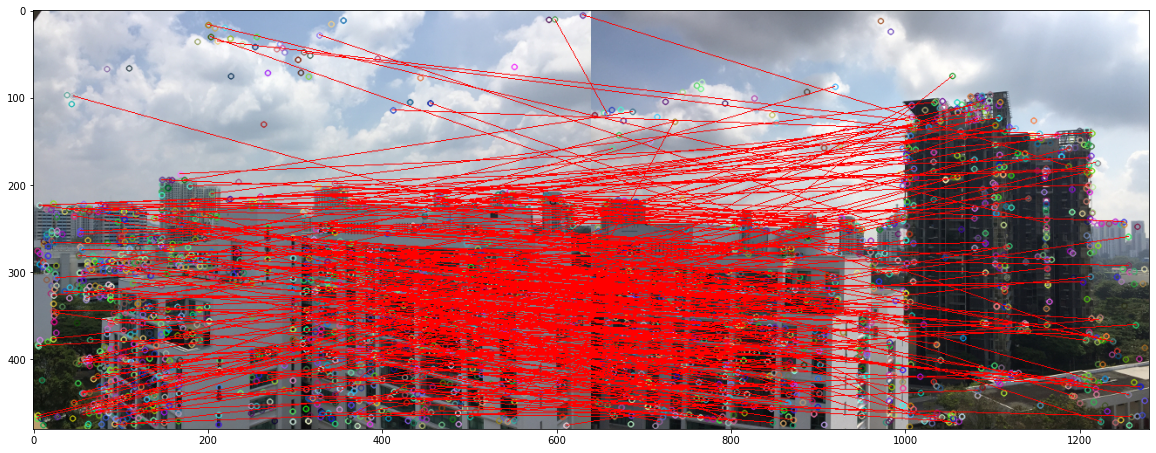

In [6]:
#delete all variables
%reset -f

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import linalg

def sift_match(des1, des2):
    d = np.zeros(des2.shape[0])
    flag = np.zeros(des1.shape[0])
    
    for m in range(0, des1.shape[0]):
        for n in range(0, des2.shape[0]):
            d2 = sum((des1[m]-des2[n])**2)
            d[n] = np.sqrt(d2)
            
        flag[m] = np.argmin(d)

    return flag        
    
#=========================================

img1 = cv2.imread('Img/im01.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img1_copy = np.tile(img1, 1)      #copy img 

img2 = cv2.imread('Img/im02.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
img2_copy = np.tile(img2, 1)    

sift = cv2.xfeatures2d.SIFT_create()

#defect
(kp1, des1) = sift.detectAndCompute(img1_copy, None)
(kp2, des2) = sift.detectAndCompute(img2_copy, None)
#draw keypoints
f1 = cv2.drawKeypoints(img1_copy, kp1, img1_copy, flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
f2 = cv2.drawKeypoints(img2_copy, kp2, img2_copy, flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
splicedImg = np.hstack((f1, f2))        #horizontally spliced img
splicedImg1 = np.tile(splicedImg, 1)    

flag = sift_match(des1, des2)
flag2 = sift_match(des2, des1)

match = []
for i in range(0, len(flag)):
    for j in range(0, len(flag2)):
        if flag[i] == j and i == flag2[j]:
            match.append([i,flag[i]])
            
for i in range(len(match)):
    x1 = kp1[int(match[i][0])].pt[0]
    y1 = kp1[int(match[i][0])].pt[1]
    x2 = kp2[int(match[i][1])].pt[0]
    y2 = kp2[int(match[i][1])].pt[1]
    d = np.sqrt(sum((des1[int(match[i][0])]-des2[int(match[i][1])])**2))
    cv2.line(splicedImg1,(int(x1),int(y1)),(int(x2)+f1.shape[1],int(y2)),(255,0,0),1)
    
plt.figure(figsize=(20,10))
plt.imshow(splicedImg1)
plt.show()

## 2.Compute the best homography matrix using RANSAC, and show all the inlier matches (matches that support your best homography matrix):

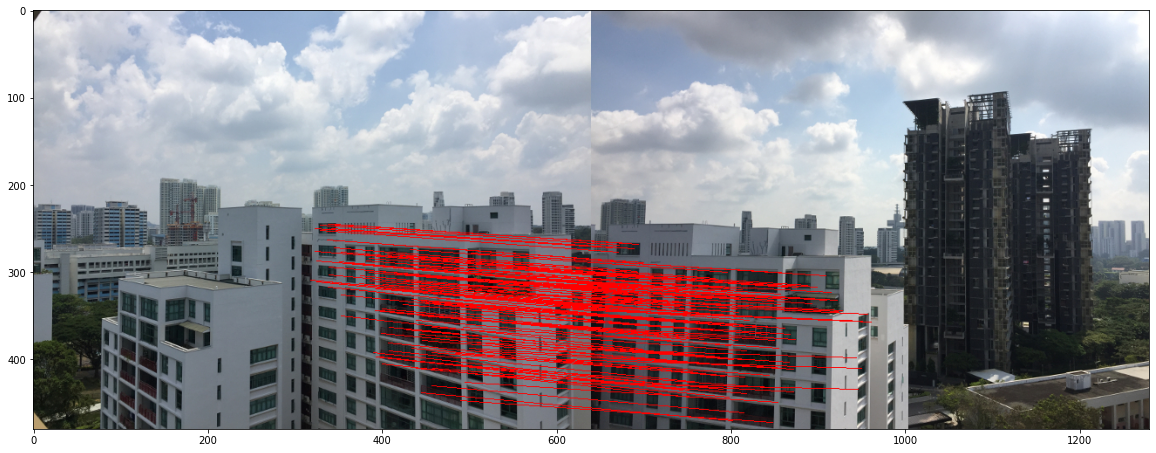

In [8]:
def getHomography_list(srcImg_coord, replace_coord):
    if len(srcImg_coord) != len(replace_coord):
        raise RuntimeError('number of points do not match, please choose 4 points')

    n = len(srcImg_coord)
    A = np.zeros((2*n,9))
    for i in range(0,n):
        A[2*i] = [srcImg_coord[i][0],srcImg_coord[i][1],1,0,0,0,
                  -replace_coord[i][0]*srcImg_coord[i][0],-replace_coord[i][0]*srcImg_coord[i][1],-replace_coord[i][0]]
        A[2*i+1] = [0,0,0,srcImg_coord[i][0],srcImg_coord[i][1],1,
                    -replace_coord[i][1]*srcImg_coord[i][0],-replace_coord[i][1]*srcImg_coord[i][1],-replace_coord[i][1]]
    U,S,V = linalg.svd(A) #SVD method
    H = V[8].reshape((3,3))
    
    return H / H[2,2]# uniformization

#from match choose 4 keypoint pairs
def choosepoint(kp1,kp2,match,n1,n2,n3,n4):
    x1 = kp1[int(match[n1][0])].pt[0]
    y1 = kp1[int(match[n1][0])].pt[1]
    x11 = kp2[int(match[n1][1])].pt[0]
    y11 = kp2[int(match[n1][1])].pt[1]
    
    x2 = kp1[int(match[n2][0])].pt[0]
    y2 = kp1[int(match[n2][0])].pt[1]
    x22 = kp2[int(match[n2][1])].pt[0]
    y22 = kp2[int(match[n2][1])].pt[1]
    
    x3 = kp1[int(match[n3][0])].pt[0]
    y3 = kp1[int(match[n3][0])].pt[1]
    x33 = kp2[int(match[n3][1])].pt[0]
    y33 = kp2[int(match[n3][1])].pt[1]
    
    x4 = kp1[int(match[n4][0])].pt[0]
    y4 = kp1[int(match[n4][0])].pt[1]
    x44 = kp2[int(match[n4][1])].pt[0]
    y44 = kp2[int(match[n4][1])].pt[1]
    
    srcImg_coord = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    replace_coord = [[x11,y11],[x22,y22],[x33,y33],[x44,y44]]

    return srcImg_coord, replace_coord

#=========================================
splicedImg2 = np.hstack((img1, img2))
e = 1.5
k = 0
iteration = 100000
final_match = []

while k < iteration:
    n1,n2,n3,n4 = np.random.randint(0,len(match),4) #choose 4 keypoint pairs
    left_coord, right_coord = choosepoint(kp1,kp2,match,n1,n2,n3,n4)
    H = getHomography_list(left_coord, right_coord)
    
    new_match = []        
    for i in range(len(match)):
        
        x1 = kp1[int(match[i][0])].pt[0]
        y1 = kp1[int(match[i][0])].pt[1]
        x2 = kp2[int(match[i][1])].pt[0]
        y2 = kp2[int(match[i][1])].pt[1]
        hx1 = (H[0][0]*x1 + H[0][1]*y1 + H[0][2]) / (H[2][0]*x1 + H[2][1]*y1 + H[2][2])
        hy1 = (H[1][0]*x1 + H[1][1]*y1 + H[1][2]) / (H[2][0]*x1 + H[2][1]*y1 + H[2][2])

        d = np.sqrt((x2 - hx1)**2 + (y2 - hy1)**2)

        if d < e:
            new_match.append(match[i])
            
    if len(new_match) > len(final_match):
        final_match = new_match 
    k += 1

img_src_coordinate = []
replace_coordinate = []
for i in range(len(final_match)):
    d = np.sqrt(sum((des1[int(final_match[i][0])]-des2[int(final_match[i][1])])**2))
    x1 = kp1[int(final_match[i][0])].pt[0]
    y1 = kp1[int(final_match[i][0])].pt[1]
    x2 = kp2[int(final_match[i][1])].pt[0]
    y2 = kp2[int(final_match[i][1])].pt[1]
    img_src_coordinate.append([x1, y1])
    replace_coordinate.append([x2, y2])
    cv2.line(splicedImg2,(int(x1),int(y1)),(int(x2) + f1.shape[1],int(y2)),(255,0,0),1)

plt.figure(figsize=(20,10))
plt.imshow(splicedImg2)
plt.show()

## 3.Stitch the images together using the best homography matrix and show the result:

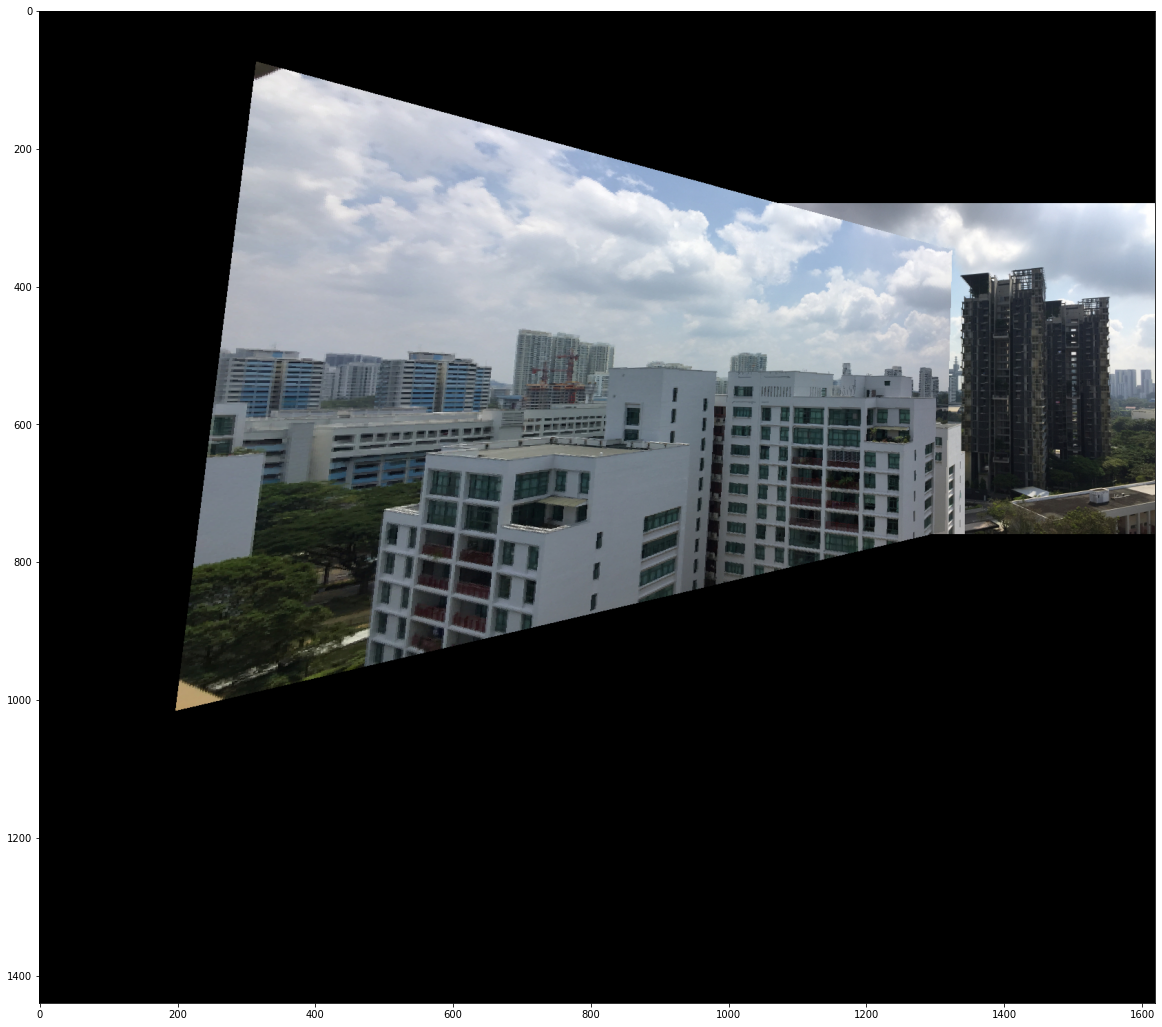

In [9]:
def getStitch(srcImg, dstImg, H, canvas_size, x0, y0, step):
    canvas = np.zeros(canvas_size)
    for i in range(x0,x0+dstImg.shape[0]):
        for j in range(y0,y0+dstImg.shape[1]):
            canvas[i][j] = dstImg[i-x0][j-y0]

    i=0
    while i < srcImg.shape[0]:
        j=0
        while j < srcImg.shape[1]:
            hx = (H[0][0]*j + H[0][1]*i + H[0][2]) / (H[2][0]*j + H[2][1]*i + H[2][2])
            hy = (H[1][0]*j + H[1][1]*i + H[1][2]) / (H[2][0]*j + H[2][1]*i + H[2][2])
            canvas[int(hy)+x0][int(hx)+y0] = srcImg[int(i)][int(j)]
            j += step
        i += step
    return canvas            
#======================================
img_src_coordinate = np.array(img_src_coordinate)
replace_coordinate = np.array(replace_coordinate)
H_best1 = getHomography_list(img_src_coordinate, replace_coordinate)
H_best2 = getHomography_list(replace_coordinate, img_src_coordinate)

canvas1 = getStitch(img1, img2, H_best1, [1440,1620,3], 280, 980, step = 0.1)

plt.figure(figsize=(20,20))
plt.imshow(canvas1.astype('uint8'))
plt.show()